# Config

In [1]:
# load model from dir
load_dir = "./model/pretrain/tune_UNet_strong_baseline"
# load model version
fea_path = "./model/pretrain/tune_UNet_strong_baseline/tune_unet_CP07_LOSS0.0549.pkl"
reg_path = "./model/pretrain/tune_UNet_strong_baseline/tune_reg_CP07_LOSS0.0549.pkl"
# Some parameters
elem = ("O", "H")
split = (0.0, 3.0)
threshold = -0.3
pos_w = (25.0, 20.0)
label = 0
# dataset path
dataset_path = "./../raw_data/bulkexp"
save_npy = True
save_poscar = True
batch_size = 2
num_workers = 6
transform = None #stan_T
filelist = "HDA.filelist"
work_dir = load_dir

# Import

In [2]:
import os
os.chdir("../")

import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import OrderedDict

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision

import model

from utils.metrics import analyse_cls, metStat
from utils.criterion import modelLoss
from datasets.dataset import AFMDataset
from utils.logger import Logger
from datasets.trans_pic import stan_T
from datasets.poscar import poscar

from utils import set_seed

In [3]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
set_seed(1)
torch.set_printoptions(precision=6,sci_mode=False)

logger = Logger(path=f"{work_dir}",log_name="test.log", elem=elem,split=split)
tb_writer = SummaryWriter(log_dir=f"{work_dir}/runs/Pred")

In [9]:
fea = model.UNetModel(image_size=(16, 128, 128),
                             in_channels=1,
                             model_channels=32,
                             out_channels=32,
                             num_res_blocks=2,
                             attention_resolutions=(8,),
                             dropout=0.0,
                             channel_mult=(1, 2, 4, 4),
                             dims=3,
                             num_heads = 4,
                             time_embed=None,
                             use_checkpoint=False).cuda()

fea.structure()

fea.load(fea_path, pretrained = True)

reg = model.Regression(in_channels=32, out_channels=8).cuda()

reg.structure()

reg.load(reg_path, pretrained = True)

net = nn.Sequential(fea, reg)

analyse = analyse_cls(threshold=0.3).cuda()
#net.structure()

log = [f"Load parameters from {load_dir}"]

LOSS = modelLoss(threshold = 0.5, pos_w = pos_w).cuda()

for l in log:
    logger.info(l)

print("Load model successfully!")

----------------------------------------------------------------------------------------------------
|                     weight name                    |          weight shape          |   number   |
----------------------------------------------------------------------------------------------------
| input_blocks.0.conv.weight                         | 32, 1, 3, 3, 3                 | 864        |
| input_blocks.0.conv.bias                           | 32,                            | 32         |
| input_blocks.1.res0.in_layers.norm.weight          | 32,                            | 32         |
| input_blocks.1.res0.in_layers.norm.bias            | 32,                            | 32         |
| input_blocks.1.res0.in_layers.conv.weight          | 32, 32, 3, 3, 3                | 27648      |
| input_blocks.1.res0.in_layers.conv.bias            | 32,                            | 32         |
| input_blocks.1.res0.out_layers.norm.weight         | 32,                            | 32 

Epoch - Test: 34it [57:22,  1.43s/it, name=HDA8_1_1_0_1]

----------------------------------------------------------------------------------------------------
|                     weight name                    |          weight shape          |   number   |
----------------------------------------------------------------------------------------------------
| in_blocks.conv0.weight                             | 64, 32, 3, 3, 3                | 55296      |
| in_blocks.conv0.bias                               | 64,                            | 64         |
| in_blocks.conv1.weight                             | 128, 64, 3, 3, 3               | 221184     |
| in_blocks.conv1.bias                               | 128,                           | 128        |
| out_blocks.conv0.weight                            | 64, 128, 1, 1, 1               | 8192       |
| out_blocks.conv0.bias                              | 64,                            | 64         |
| out_blocks.conv1.weight                            | 8, 64, 1, 1, 1                 | 512

# make Dataset

IMG: torch.Size([1, 16, 128, 128]), filename: HDA3_-1_-1_0_0
Load data successfully!


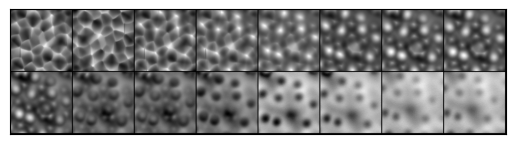

In [6]:

dataset = AFMDataset(dataset_path, preload= False, label = label, img_use= 16, transform = transform, file_list = filelist)

data_loader = torch.utils.data.DataLoader(dataset, 
                                      batch_size=batch_size, 
                                      num_workers=num_workers, 
                                      pin_memory=True, 
                                      shuffle=False, 
                                      )

if label:
    for imgs, gt_box, filename in data_loader:
        print(f"IMG: {imgs[0].shape}, filename: {filename[0]}")
        break
else:
    for imgs, filename in data_loader:
        print(f"IMG: {imgs[0].shape}, filename: {filename[0]}")
        break

show(make_grid(imgs[0].permute(1,0,2,3)))

print("Load data successfully!")

# Start Predicting

In [7]:
T_dict = OrderedDict(Loss=metStat(mode="mean"))
len_loader = len(data_loader)
it_loader = iter(data_loader)

pbar = tqdm(total=len_loader - 1,
                    desc=f"Epoch - Test", position=0, leave=True, unit='it')

net.eval()
with torch.no_grad():
    i = 0
    while i < len_loader:
        if label:
            imgs, gt_box, filename = next(it_loader)
            gt_box = gt_box.cuda(non_blocking=True)
        else:
            imgs, filename = next(it_loader)
            
        imgs = imgs.cuda(non_blocking=True)
        pd_box = net(imgs)
        if label:
            analyse(pd_box, gt_box)
            T_dict['Loss'].add(LOSS(pd_box, gt_box))
        if save_npy:
            for pd, f in zip(pd_box, filename):
                if not os.path.exists(f"{dataset_path}/npy"):
                    os.mkdir(f"{dataset_path}/npy")
                torch.save(pd.detach().cpu(), f"{dataset_path}/npy/{f}.npy")
        if save_poscar:
            for pd, f in zip(pd_box, filename):
                if not os.path.exists(f"{dataset_path}/result/{load_dir.split('/')[-1]}"):
                    os.mkdir(f"{dataset_path}/result/{load_dir.split('/')[-1]}")
                pos_dict = poscar.box2pos(pd, order = elem, threshold= threshold)
                poscar.pos2poscar(f"{dataset_path}/result/{load_dir.split('/')[-1]}/{f}.poscar", pos_dict)
        pbar.set_postfix(name = filename[0])
        i += 1
        pbar.update(1)

Epoch - Test: 34it [00:48,  1.43s/it, name=HDA8_1_1_0_1]                          

In [8]:
info = f"\nEpoch = Test" + "\n"
info += f"Max memory use = {torch.cuda.max_memory_allocated() / 1024 / 1024:.2f}MB" + "\n"
info += f"TEST INFO:"
if label:
    for name, value in T_dict.items():
        info += f" {name} = {value:6.3f}"
        info += "\n" 
    MET = analyse.summary()
    for e in MET.elems:
        info += f"{e}"
        for l in MET.split:
            info += f"\t{l}"
            for met_name, met_format, met in zip(MET.met, MET.format, MET[e,l]):
                if met_format == "sum":
                    info += f" {met_name} = {met:8.0f},"
                else:
                    info += f" {met_name} = {met:6.4f}"
            info += "\n"
logger.info(info)

Epoch - Test: 34it [00:49,  1.43s/it, name=HDA8_1_1_0_1]

Main - 10:16:15 - INFO: 
Epoch = Test
Max memory use = 1444.15MB
TEST INFO:
